# 0 테스트 데이터의 인덱스 고르기

# 1 n*m 크기의 임의의 오분류 테스트 데이터의 피처 맵 K개 생성
* random.seed(42)로 랜덤하게 나오는 것을 일정하게 만들어준다
* 피처 맵 계산 연습을 위한 K개의 n*m 사이즈의 테스트 데이터셋 생성

In [132]:
import numpy as np
import random

random_seed_id = 4543

random.seed(random_seed_id)
random_start = 1; random_end = 1000000

K = 10000
n = 5; m = 6

# shape이 (1, n, m)인 빈 np.array를 만듦
WTD_set = np.empty((K, n, m), dtype="int32")

for k in range(K):
    WTD = np.array([[random.randint(random_start, random_end) for i in range(m)] for j in range(n)], dtype="int32")
    # np.append는 내장 append 함수와 다르게 차원이 같아야 append됨
    WTD_set = np.append(WTD_set, WTD.reshape(1, n, m), axis = 0)

WTD_set = np.delete(WTD_set, 0, axis=0)

# print(WTD_set)

# 2 베이스 피처맵 임의로 할당

실제로는 학습 데이터의 피처 맵의 평균인 베이스 피처 맵을 입력으로 받아야 함.

In [133]:
# 랜덤하게 나오는 값 고정
random.seed(random_seed_id + 123)

BFM = np.array([[random.randint(random_start, random_end) for i in range(m)] for j in range(n)], dtype="int32")

# print(BFM)

# 3 각 인덱스의 유클리드 거리에 대한 중간값, 평균, 표준편차 행렬을 구함
* 각 인덱스 (i,j)에서 오분류 테스트 데이터의 피처 맵과 베이스 피처 맵 사이의 유클리드 거리를 K개 나열할 때 이에 대한 중간값, 평균, 표준편차를 저장하는 행렬들 생성

**중간값**과 **평균**과 **표준편차**도 저장함

In [134]:
# 각 인덱스 (i,j)에서 middle의 원소들은 그 인덱스 (i,j)에서 베이스 피처 맵와 오분류 테스트 데이터의 피처 맵의 거리를 K개 나열할 때
# 이 값들에 대한 중간값이어야 한다.
middle = np.empty((n,m), dtype="int32")
mean = np.empty((n,m), dtype="int32")
std = np.empty((n,m), dtype="int32")
min = np.empty((n,m), dtype="int32")
max = np.empty((n,m), dtype="int32")
ED_arrays = np.empty((n,m)).tolist()

for i in range(n):
    for j in range(m):
        ED_array_i_j = np.empty((0), dtype="int32")
        for k in range(K):
            # 거리를 구해야 하므로 내장함수 abs를 씀
            ED_array_i_j = np.append(ED_array_i_j, abs(BFM[i][j] - WTD_set[k][i][j]))
        
        # 각 인덱스에서 유클리드 거리에 대한 중간값 평균 표준편차를 구하는 것임.
        ED_arrays[i][j] = ED_array_i_j
        middle[i][j] = sorted(ED_array_i_j)[K // 2]
        mean[i][j] = ED_array_i_j.mean()
        std[i][j] = ED_array_i_j.std()
        min[i][j] = ED_array_i_j.min()
        max[i][j] = ED_array_i_j.max()

# print("middle")
# print(middle)
# print("mean")
# print(mean)
# print("middle > mean")
# print(middle > mean)
# print("std")
# print(std)

# 4 베이스 피처 맵과 테스트 데이터의 피처맵 사이의 거리를 구함.



### 4.1 처음 착수보고서에 작성된 거리를 구하는 알고리즘은 다음과 같음

* 알고리즘으로 거리를 구함

In [135]:
WTD_set_FMD = np.empty((0), dtype="int32")
for k in range(K):
    WTD_k_FMD = 0
    for i in range(n):
        for j in range(m):
            WTD_k_FMD += (ED_arrays[i][j][k] / middle[i][j])**2
    
    WTD_set_FMD = np.append(WTD_set_FMD, WTD_k_FMD)

* 알고리즘으로 구한 **거리에 대한 데이터들을 그래프**로 표현함

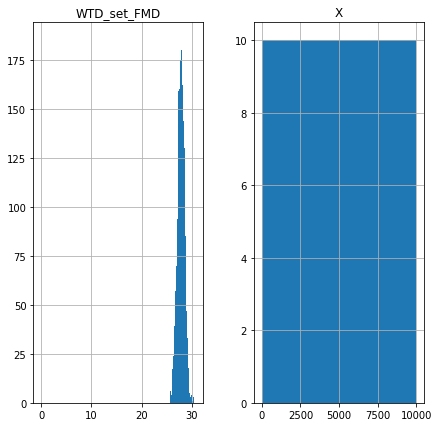

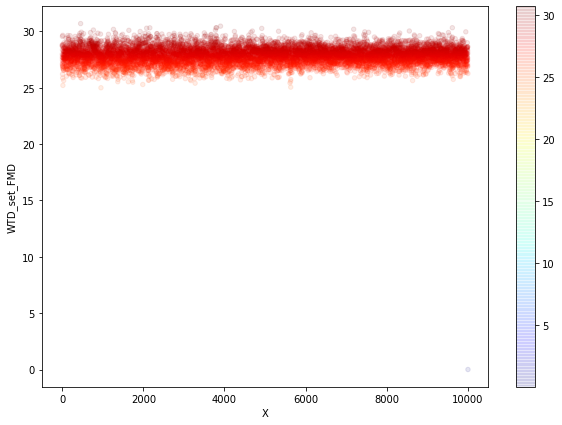

In [136]:
import pandas as pd
import matplotlib.pyplot as plt

X = [i for i in range(K)]

Columns = ["WTD_set_FMD", "X"]

df_X_WTD_set_FMD = pd.DataFrame(np.append(WTD_set_FMD.reshape(1,K), np.array(X).reshape(1,K), axis=0).T, columns=Columns)

df_X_WTD_set_FMD.hist(bins=1000, figsize=(7,7))

df_X_WTD_set_FMD.plot(kind="scatter", x="X", y="WTD_set_FMD", alpha=0.1,
                      figsize=(10,7), c=df_X_WTD_set_FMD["WTD_set_FMD"],
                      cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)

plt.show()

## 4.2 정규화를 시켜서 거리를 구함

* 정규화시키면 대략적으로 0보다 작은 값이 절반이고 0보다 큰 값이 절반 정도이다.  
* 따라서, exponential 함수를 쓰면 작은 값은 더 작아지고 큰 값은 더 커질 수 있다.  
* 그것에 대한 알고리즘을 짜려고 한다.

In [137]:
from math import exp

WTD_set_FMD = np.empty((0), dtype="int32")
for k in range(K):
    WTD_k_FMD = 0
    for i in range(n):
        for j in range(m):
            WTD_k_FMD += exp(((ED_arrays[i][j][k] - middle[i][j]) / std[i][j]))
    
    WTD_set_FMD = np.append(WTD_set_FMD, WTD_k_FMD)

* 거리에 대한 그래프를 그린다.

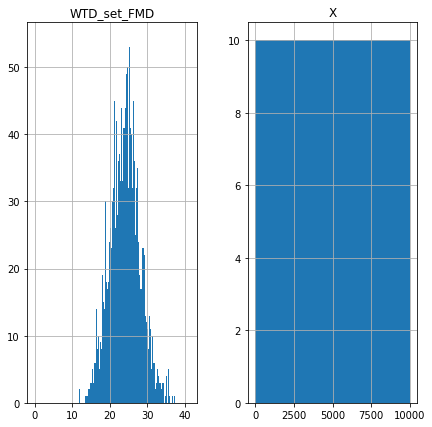

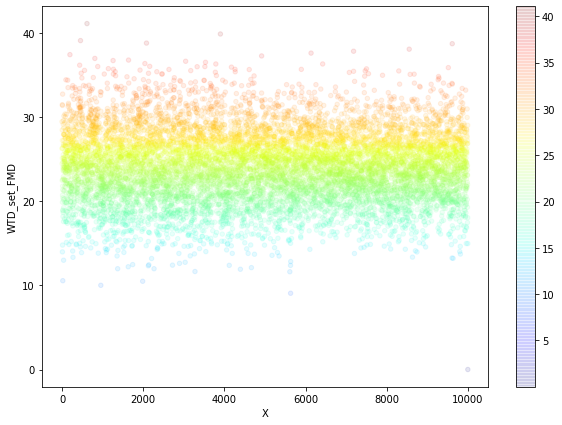

In [138]:
import pandas as pd

X = [i for i in range(K)]

Columns = ["WTD_set_FMD", "X"]

df_X_WTD_set_FMD = pd.DataFrame(np.append(WTD_set_FMD.reshape(1,K), np.array(X).reshape(1,K), axis=0).T, columns=Columns)

df_X_WTD_set_FMD.hist(bins=1000, figsize=(7,7))

df_X_WTD_set_FMD.plot(kind="scatter", x="X", y="WTD_set_FMD", alpha=0.1,
                      figsize=(10,7), c=df_X_WTD_set_FMD["WTD_set_FMD"],
                      cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)

plt.show()

### 4.2.1 정규화(normalization)에 대한 데이터 특징

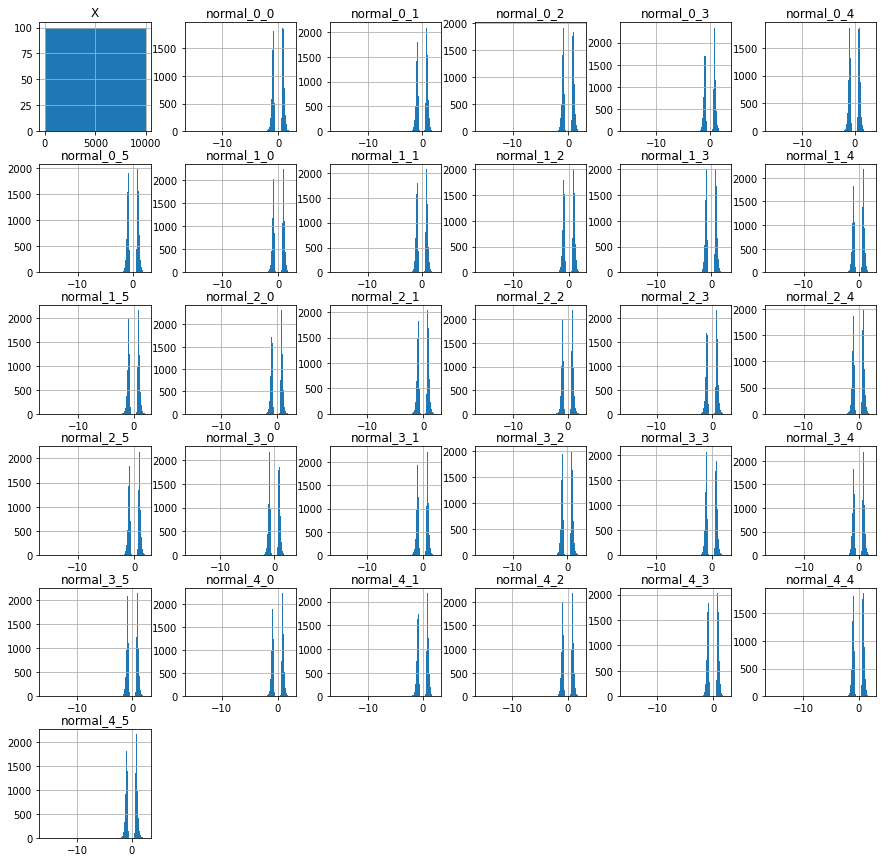

In [139]:
%matplotlib inline
import pandas as pd

normals = []

for i in range(n):
    for j in range(m):
        normal_i_j = []
        for k in range(K):
            normal_i_j.append((abs(BFM[i][j] - WTD_set[k][i][j]) - mean[i][j]) / std[i][j])
        normals.append(normal_i_j)

X = [i for i in range(K)]
normals.insert(0, X)

X_normals = np.array(normals).T

Columns_X_normals = ["X"]

for i in range(n):
    for j in range(m):
        Columns_X_normals.append(f"normal_{i}_{j}")

df_X_normals = pd.DataFrame(X_normals, columns=Columns_X_normals)

df_X_normals.hist(bins=100,figsize=(15,15))

for i in range(n):
    for j in range(m):
        # df_X_normals.plot(kind="scatter", x="X", y="normal_"+f"{i}"+"_"+f"{j}", alpha=0.05)
        pass

plt.show()


## 4.3 min-max과 shift를 이용해 거리를 구함

* min-max으로 데이터를 0\~1로 표준화를 시킨 후에 그 데이터의 middle보다 작거나 같은 값은 0\~1 사이의 값인데 제곱을 취하여 더 작은 값이 되도록 만든다.
* middle보다 큰 값은 middle이 1이 되도록 shift한 후 제곱을 취하여 더 큰 값이 되도록 한다.
* 거리의 maximum은 4 * K(테스트 케이스의 수)이다.

In [140]:
WTD_set_FMD = np.empty((0), dtype="int32")
for k in range(K):
    WTD_k_FMD = 0
    for i in range(n):
        for j in range(m):
            min_max_distance = (ED_arrays[i][j][k] - min[i][j]) / max[i][j]
            min_max_distance_of_middle = (middle[i][j]- min[i][j]) / max[i][j]
            if ED_arrays[i][j][k] <= middle[i][j]:
                WTD_k_FMD += (min_max_distance)**2
            else:
                WTD_k_FMD += (min_max_distance + 1 - min_max_distance_of_middle)**2
    
    WTD_set_FMD = np.append(WTD_set_FMD, WTD_k_FMD)



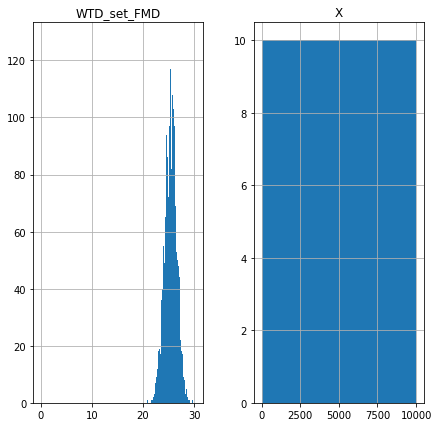

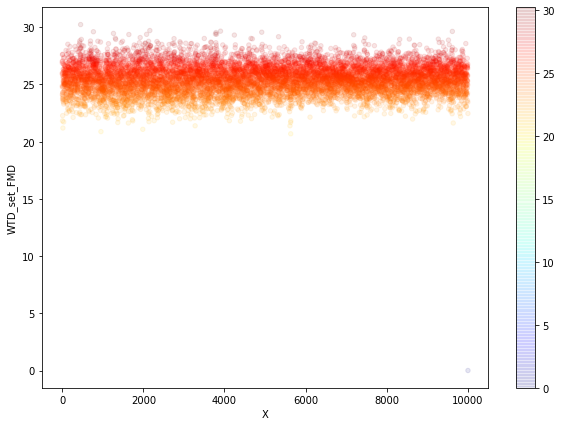

In [141]:
import pandas as pd

X = [i for i in range(K)]

Columns = ["WTD_set_FMD", "X"]

df_X_WTD_set_FMD = pd.DataFrame(np.append(WTD_set_FMD.reshape(1,K), np.array(X).reshape(1,K), axis=0).T, columns=Columns)

df_X_WTD_set_FMD.hist(bins=1000, figsize=(7,7))

df_X_WTD_set_FMD.plot(kind="scatter", x="X", y="WTD_set_FMD", alpha=0.1,
                      figsize=(10,7), c=df_X_WTD_set_FMD["WTD_set_FMD"],
                      cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)

plt.show()

# *연습

## *.1 각 인덱스에서 K개의 오분류 데이터에 대한 평균과 중간값의 관계를 살펴봄

In [142]:
from matplotlib import pyplot as plt

# 각 인덱스에서 평균보다 낮은 값들의 수와 높은 값들의 수를 출력
for i in range(n):
    for j in range(m):
        higher_than_mean = np.array((ED_arrays[i][j] > mean[i][j]))
        higher_count = np.count_nonzero(higher_than_mean)
        print(f"(L: {K - higher_count}, H: {higher_count})", end = ' ')
    print()

(L: 4775, H: 5225) (L: 4781, H: 5219) (L: 4845, H: 5155) (L: 4820, H: 5180) (L: 4759, H: 5241) (L: 4902, H: 5098) 
(L: 4840, H: 5160) (L: 4873, H: 5127) (L: 4872, H: 5128) (L: 4878, H: 5122) (L: 4732, H: 5268) (L: 4848, H: 5152) 
(L: 4779, H: 5221) (L: 4809, H: 5191) (L: 4796, H: 5204) (L: 4748, H: 5252) (L: 4785, H: 5215) (L: 4872, H: 5128) 
(L: 4966, H: 5034) (L: 4840, H: 5160) (L: 4925, H: 5075) (L: 4862, H: 5138) (L: 4786, H: 5214) (L: 4884, H: 5116) 
(L: 4787, H: 5213) (L: 4813, H: 5187) (L: 4917, H: 5083) (L: 4902, H: 5098) (L: 4828, H: 5172) (L: 4780, H: 5220) 


## *.2 행렬 크기에 상관없이 거리 계산을 적용할 수 있도록 만들기

이건 아마도 필요 없을 것 같다.

In [143]:
# 오분류 테스트 데이터의 데이터 모양 구하기
data = WTD_set[0]
shape = data.shape
# 데이터 모양의 각 차원에 대한 index_max 구해서 N에 넣기
N = np.empty((0), dtype="int32")
print(N)
for dimension_index_max in shape:
    N = np.append(N, dimension_index_max)

N = np.array(N)

print(N)

I = [0 for i in range(len(N))]

middle_ = np.empty(N, dtype="int32")
mean_ = np.empty(N, dtype="int32")
std_ = np.empty(N, dtype="int32")
arrays_index_ = np.empty(N).tolist()

def set_matrices(I, D):
    if D == -1:
        for k in K:
            pass

        return

    for i in range(N[D]):
        I[D] = i
        set_matrices(I, D-1)

#

[]
[5 6]


## *.3 np.append에서 axis를 따라 더한다는 것에 대한 고찰

In [144]:
N = 4
M = 5
L = 6

A = np.empty((N,M,L), dtype="int32")
B = np.empty((N,M,L))
D = np.empty((N,9,L))

for n in range(N):
    for m in range(M):
        for l in range(L):
            A[n][m][l] = (n+1)*100 + (m+1)*10 + (l+1) + 10000000
            B[n][m][l] = ((n+1)*100 + (m+1)*10 + (l+1))*1000 + 20000000

# print(A)
# print(B)
# C0 = np.append(A, B, axis=0)
# C1 = np.append(A, B, axis=1)
# C2 = np.append(A, B, axis=2)
# print("----------------------------------C0----------------------------------")
# print(C0)
# print("----------------------------------C1----------------------------------")
# print(C1)
# print("----------------------------------C2----------------------------------")
# print(C2)

E = np.append(A, D, axis=1)


## *.4 삼차원 데이터 그리기

matploblib 모듈에서 그래프 그리는 것에 대한 메소드를 다양하게 알아둘 필요가 있다.

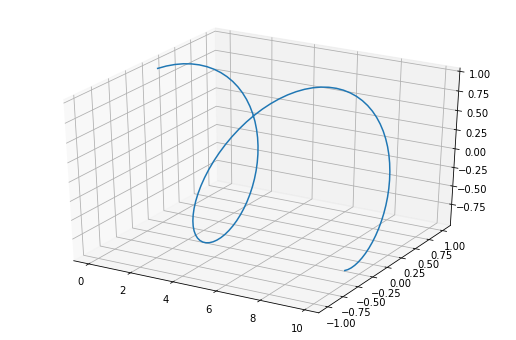

In [145]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

x = np.arange(0, 10, 0.1)
y = np.sin(x)
z = np.cos(x)
ax.plot(x, y, z)

# 5 resnet 모델 가지고 오기

In [146]:
from torchvision import models
from torchsummary import summary
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 학습 환경 설정
model = models.resnet50(pretrained=True).to(device) # true 옵션으로 사전 학습된 모델을 로드

# summary(model, (3, 128, 128))